# PROJECT LUNG DISEASES

# REQUIREMENT

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


# Initiation Directory

In [3]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

# Datagenerator

In [4]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle= True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 16
)
batch_size=16
image_size = 224

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

In [8]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False
    
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(Dense(64,activation='relu'))
model_resnet50.add(Dense(128,activation='relu'))
model_resnet50.add(Dense(512,activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(5, 
                       activation='softmax'))
model_resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 64)          131136    
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 128)         8320      
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 512)         66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/30
380/380 [==============================] - 41s 100ms/step - loss: 1.5517 - acc: 0.3013 - val_loss: 1.3491 - val_acc: 0.4776
Epoch 2/30
380/380 [==============================] - 37s 98ms/step - loss: 1.2983 - acc: 0.4635 - val_loss: 1.0763 - val_acc: 0.5703
Epoch 3/30
380/380 [==============================] - 36s 96ms/step - loss: 1.1290 - acc: 0.5367 - val_loss: 0.9617 - val_acc: 0.6354
Epoch 4/30
380/380 [==============================] - 38s 100ms/step - loss: 1.0268 - acc: 0.5809 - val_loss: 0.8879 - val_acc: 0.6589
Epoch 5/30
380/380 [==============================] - 38s 100ms/step - loss: 0.9697 - acc: 0.6000 - val_loss: 0.9540 - val_acc: 0.6181
Epoch 6/30
380/380 [==============================] - 38s 99ms/step - loss: 0.9324 - acc: 0.6137 - val_loss: 0.8541 - val_acc: 0.6375

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/30
380/380 [==============================] - 38s 99ms/step - loss: 0.8748 - acc: 0.6444 - val_loss: 0.8

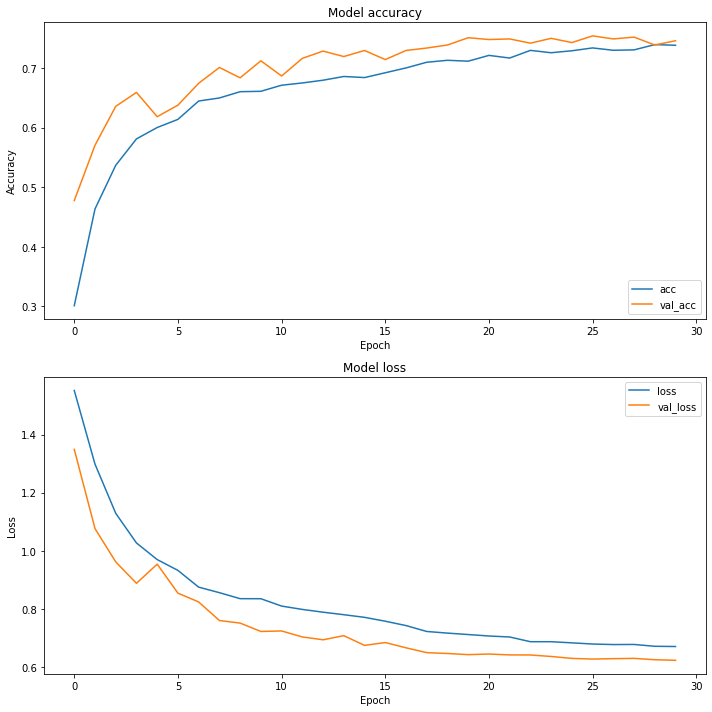

In [10]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_resnet50.history["acc"])
plt.plot(history_resnet50.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [11]:
train_score = model_resnet50.evaluate(train_generator, verbose=1)
test_score = model_resnet50.evaluate(val_generator, verbose=1)

62/62 [==============================] - 6s 94ms/step - loss: 0.6229 - acc: 0.7454


Found 982 images belonging to 5 classes.
62/62 [==============================] - 7s 80ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21805   0.14078   0.17109       206
            covid19    0.21852   0.27962   0.24532       211
             normal    0.21569   0.21053   0.21308       209
       tuberculosis    0.13333   0.11429   0.12308       140
    viral_pneumonia    0.24314   0.28704   0.26327       216

           accuracy                        0.21385       982
          macro avg    0.20574   0.20645   0.20317       982
       weighted avg    0.21109   0.21385   0.20941       982



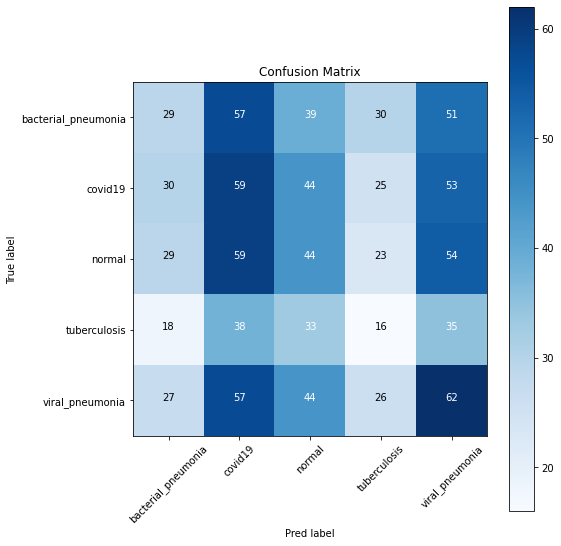

In [11]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 33s 84ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.74677   0.75902   0.75285      1220
            covid19    0.68764   0.76508   0.72430      1243
             normal    0.76858   0.66154   0.71105      1235
       tuberculosis    0.77571   0.81880   0.79667      1170
    viral_pneumonia    0.71096   0.67987   0.69507      1212

           accuracy                        0.73618      6080
          macro avg    0.73793   0.73686   0.73599      6080
       weighted avg    0.73754   0.73618   0.73544      6080



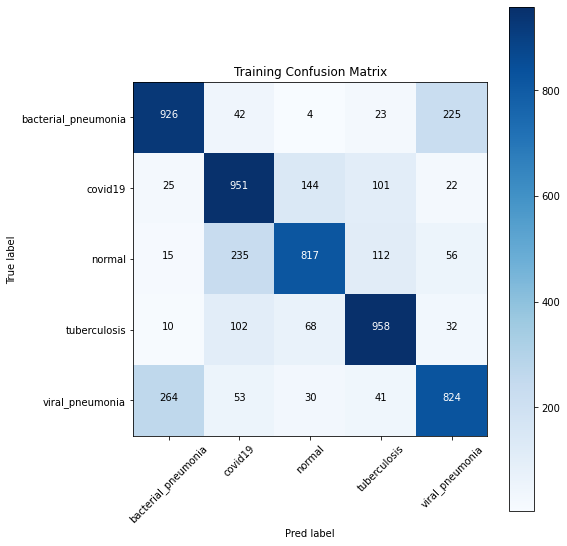

In [12]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [13]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Dense(64,activation='relu'))
model_vgg19.add(Dense(128,activation='relu'))
model_vgg19.add(Dense(512,activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(5, 
                       activation='softmax'))

model_vgg19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense_7 (Dense)              (None, 7, 7, 64)          32832     
_________________________________________________________________
dense_8 (Dense)              (None, 7, 7, 128)         8320      
_________________________________________________________________
dense_9 (Dense)              (None, 7, 7, 512)         66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_______________________________________________________

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)


In [15]:
history_vgg19 = model_vgg19.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/30
380/380 [==============================] - 44s 105ms/step - loss: 0.9997 - acc: 0.6176 - val_loss: 0.6571 - val_acc: 0.7077
Epoch 2/30
380/380 [==============================] - 38s 99ms/step - loss: 0.6160 - acc: 0.7516 - val_loss: 0.4876 - val_acc: 0.8065
Epoch 3/30
380/380 [==============================] - 38s 100ms/step - loss: 0.5209 - acc: 0.7903 - val_loss: 0.4886 - val_acc: 0.7933
Epoch 4/30
380/380 [==============================] - 38s 100ms/step - loss: 0.4600 - acc: 0.8234 - val_loss: 0.4416 - val_acc: 0.8208
Epoch 5/30
380/380 [==============================] - 38s 99ms/step - loss: 0.4178 - acc: 0.8395 - val_loss: 0.3913 - val_acc: 0.8544
Epoch 6/30
380/380 [==============================] - 38s 99ms/step - loss: 0.3860 - acc: 0.8477 - val_loss: 0.4253 - val_acc: 0.8299
Epoch 7/30
380/380 [==============================] - 39s 103ms/step - loss: 0.3594 - acc: 0.8640 - val_loss: 0.3446 - val_acc: 0.8656
Epoch 8/30
380/380 [==============================] - 39s 

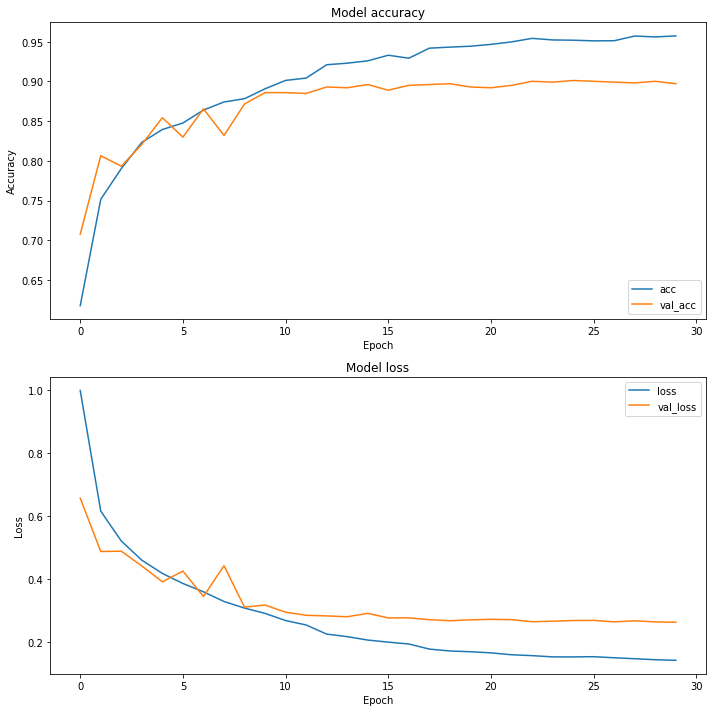

In [16]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_vgg19.history["acc"])
plt.plot(history_vgg19.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history["loss"])
plt.plot(history_vgg19.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [17]:
train_score = model_vgg19.evaluate(train_generator, verbose=1)
test_score = model_vgg19.evaluate(val_generator, verbose=1)

62/62 [==============================] - 6s 94ms/step - loss: 0.2627 - acc: 0.8971


Found 982 images belonging to 5 classes.
62/62 [==============================] - 6s 94ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19907   0.20874   0.20379       206
            covid19    0.24286   0.24171   0.24228       211
             normal    0.18269   0.18182   0.18225       209
       tuberculosis    0.11029   0.10714   0.10870       140
    viral_pneumonia    0.26415   0.25926   0.26168       216

           accuracy                        0.20672       982
          macro avg    0.19981   0.19973   0.19974       982
       weighted avg    0.20665   0.20672   0.20665       982



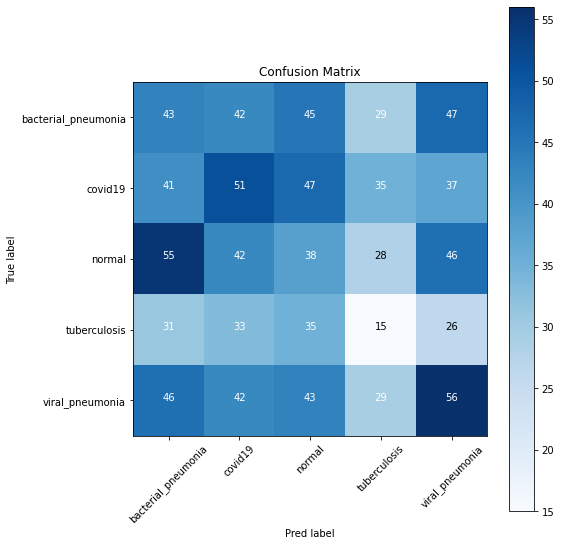

In [18]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 33s 88ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.94668   0.94590   0.94629      1220
            covid19    0.96380   0.96380   0.96380      1243
             normal    0.96997   0.96761   0.96879      1235
       tuberculosis    0.98549   0.98718   0.98634      1170
    viral_pneumonia    0.94316   0.94472   0.94394      1212

           accuracy                        0.96168      6080
          macro avg    0.96182   0.96184   0.96183      6080
       weighted avg    0.96168   0.96168   0.96168      6080



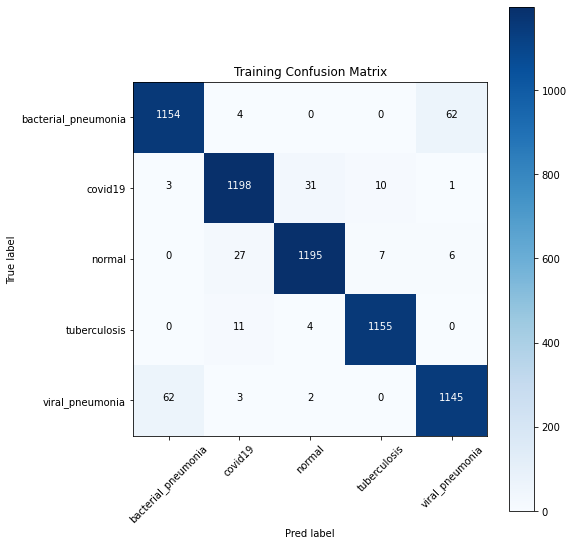

In [20]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


In [21]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(Dense(64,activation='relu'))
model_inceptionv3.add(Dense(128,activation='relu'))
model_inceptionv3.add(Dense(512,activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(5, 
                       activation='softmax'))

model_inceptionv3.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dense_11 (Dense)             (None, 5, 5, 64)          131136    
_________________________________________________________________
dense_12 (Dense)             (None, 5, 5, 128)         8320      
_________________________________________________________________
dense_13 (Dense)             (None, 5, 5, 512)         66048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_______________________________________________________

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/30
380/380 [==============================] - 42s 98ms/step - loss: 0.8430 - acc: 0.6470 - val_loss: 0.6736 - val_acc: 0.7016
Epoch 2/30
380/380 [==============================] - 35s 91ms/step - loss: 0.5474 - acc: 0.7745 - val_loss: 0.5113 - val_acc: 0.7872
Epoch 3/30
380/380 [==============================] - 35s 92ms/step - loss: 0.4337 - acc: 0.8242 - val_loss: 0.4668 - val_acc: 0.8136
Epoch 4/30
380/380 [==============================] - 35s 91ms/step - loss: 0.3608 - acc: 0.8617 - val_loss: 0.4709 - val_acc: 0.8055
Epoch 5/30
380/380 [==============================] - 35s 92ms/step - loss: 0.2977 - acc: 0.8822 - val_loss: 0.4309 - val_acc: 0.8259
Epoch 6/30
380/380 [==============================] - 35s 92ms/step - loss: 0.2439 - acc: 0.9056 - val_loss: 0.4373 - val_acc: 0.8228
Epoch 7/30
380/380 [==============================] - 35s 92ms/step - loss: 0.1943 - acc: 0.9321 - val_loss: 0.4657 - val_acc: 0.8218

Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.99

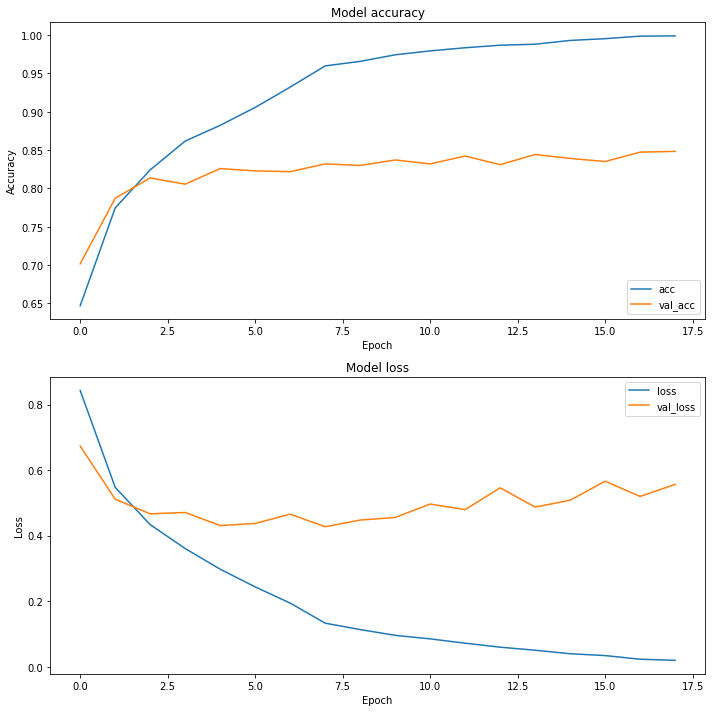

In [26]:

plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_inceptionv3.history["acc"])
plt.plot(history_inceptionv3.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_inceptionv3.history["loss"])
plt.plot(history_inceptionv3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [27]:
train_score = model_inceptionv3.evaluate(train_generator, verbose=1)
test_score = model_inceptionv3.evaluate(val_generator, verbose=1)

62/62 [==============================] - 6s 93ms/step - loss: 0.4272 - acc: 0.8320


Found 982 images belonging to 5 classes.
62/62 [==============================] - 7s 93ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19178   0.20388   0.19765       206
            covid19    0.26923   0.26540   0.26730       211
             normal    0.20101   0.19139   0.19608       209
       tuberculosis    0.11189   0.11429   0.11307       140
    viral_pneumonia    0.22066   0.21759   0.21911       216

           accuracy                        0.20468       982
          macro avg    0.19891   0.19851   0.19864       982
       weighted avg    0.20535   0.20468   0.20494       982



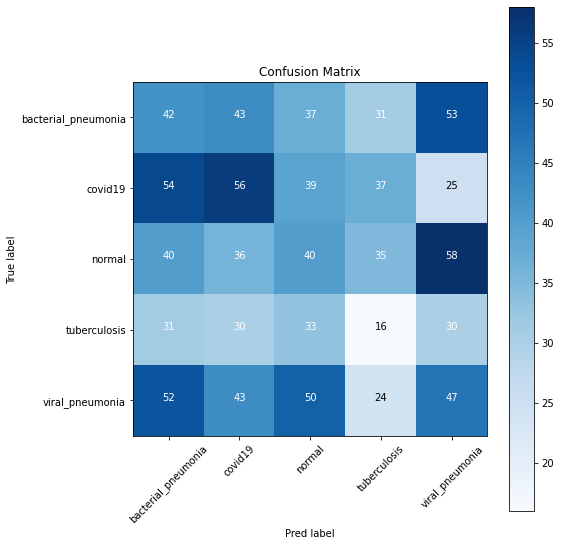

In [28]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 30s 78ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.97327   0.95492   0.96400      1220
            covid19    0.99346   0.97828   0.98581      1243
             normal    0.98697   0.98138   0.98417      1235
       tuberculosis    0.99235   0.99829   0.99531      1170
    viral_pneumonia    0.94179   0.97442   0.95783      1212

           accuracy                        0.97730      6080
          macro avg    0.97757   0.97746   0.97742      6080
       weighted avg    0.97758   0.97730   0.97735      6080



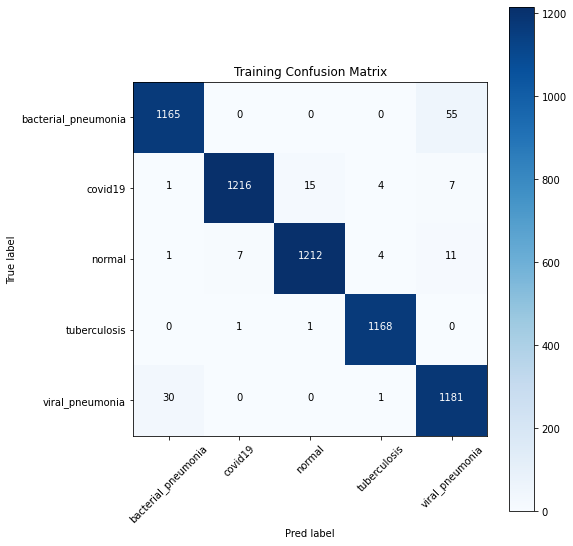

In [29]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()